In [2]:
import csv
import numpy as np
import pandas as pd
import re
from gensim.models import KeyedVectors
import morfeusz2
from Levenshtein import distance
from collections import Counter
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm  
import os.path
import json
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime

Importing plotly failed. Interactive plots will not work.


In [3]:
df_org = pd.read_excel('../shumee_mckinsey -Aktualizacja 01.03.xlsx', index_col=None, engine='openpyxl')

In [25]:
df = df_org[['Data', 'Nazwa produktu']]
df

,Data,Nazwa produktu
0,2021-02-28 23:52:46,PEPCO Ramka na clip 53x63 cm srebrna
1,2021-02-28 23:50:05,shumee Ručně vyrobený kuchyňský dřez se sítkem...
2,2021-02-28 23:50:05,shumee Venkovní solární sprcha se sprchovou hl...
3,2021-02-28 23:48:57,Fontanna ze stali nierdzewnej do basenu ogrodo...
4,2021-02-28 23:39:51,"Krzesła biurowe, 2 szt., pomarańczowe, sztuczn..."
...,...,...
190543,2018-02-26 19:44:13,Kod rabatowy: shumeeLOVE
190544,2018-02-26 15:37:29,U.S. Polo - 43481_47130 XXL
190545,2018-02-26 15:20:26,Made in Italia - FEDERICA 36
190546,2018-02-26 02:08:48,Versace Jeans - E1VPBBT1_75416


In [26]:
clustered_productsJSON = None
clustered_products = {}
id_to_product = {}
with open('clustered_products.json') as f:
    clustered_productsJSON = json.load(f)
for i in range(len(clustered_productsJSON)):
    for prd in clustered_productsJSON[i]:
        clustered_products[prd] = i
        id_to_product[i] = prd

In [27]:
dates = []
begin = datetime.date(2018, 2, 1)
end = datetime.date(2021, 3, 1)
x = datetime.date(2020, 12, 1)
while (begin < end):
    dates.append(begin)
    begin += relativedelta(months=+1)
print(dates)

[datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1), datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1), datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1), datetime.date(2019, 1, 1), datetime.date(2019, 2, 1), datetime.date(2019, 3, 1), datetime.date(2019, 4, 1), datetime.date(2019, 5, 1), datetime.date(2019, 6, 1), datetime.date(2019, 7, 1), datetime.date(2019, 8, 1), datetime.date(2019, 9, 1), datetime.date(2019, 10, 1), datetime.date(2019, 11, 1), datetime.date(2019, 12, 1), datetime.date(2020, 1, 1), datetime.date(2020, 2, 1), datetime.date(2020, 3, 1), datetime.date(2020, 4, 1), datetime.date(2020, 5, 1), datetime.date(2020, 6, 1), datetime.date(2020, 7, 1), datetime.date(2020, 8, 1), datetime.date(2020, 9, 1), datetime.date(2020, 10, 1), datetime.date(2020, 11, 1), datetime.date(2020, 12, 1), datetime.date(2021, 1, 1), datetime.date(2021

In [28]:

df['group'] = df['Nazwa produktu'].apply(lambda x: clustered_products[x] if x in clustered_products else -1)
df['ds'] = df['Data'].dt.date.apply(lambda x: x.replace(day=1))
print(df['Data'].min())

df.drop('Data', inplace=True, axis=1)

df.drop('Nazwa produktu', inplace=True, axis=1)
df = df.groupby(by=['ds', 'group']).size().reset_index(name='y')
# train_DF = list(df.loc[(df['DS'] < x)])
# test_DF = list(df.loc[(df['DS'] >= x)].groupby("group"))
splits = list(df.groupby("group"))

<ipython-input-28-627c69d54e01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['Nazwa produktu'].apply(lambda x: clustered_products[x] if x in clustered_products else -1)
<ipython-input-28-627c69d54e01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = df['Data'].dt.date.apply(lambda x: x.replace(day=1))
/home/pk/.local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

2018-02-26 02:08:48


In [29]:
lst = []
for i in splits:
    s = 0
    for k in i[1].iterrows():
        s+= k[1]['y']
    lst.append((s, i[0]))
lst.sort(reverse=True)
print(lst[:100])
top100sale = []
for i in lst[:100]:
    top100sale.append(i[1])
print(top100sale)

[(43201, -1), (4204, 14), (2958, 7), (2680, 1359), (2335, 7736), (1996, 8481), (1489, 33), (1320, 60), (1167, 26), (989, 8861), (942, 217), (925, 9), (917, 5777), (895, 7308), (878, 1237), (858, 16), (792, 8486), (781, 18), (734, 56), (727, 7947), (709, 6040), (661, 943), (617, 6108), (605, 8439), (601, 7032), (600, 8228), (592, 7565), (560, 8199), (559, 7907), (524, 8780), (523, 8789), (521, 5887), (517, 1141), (498, 51), (477, 6741), (475, 8349), (466, 7805), (454, 7152), (439, 5606), (429, 2060), (425, 4), (424, 6605), (417, 89), (411, 8952), (407, 8150), (402, 30), (385, 1534), (378, 37), (376, 8060), (371, 8265), (367, 6923), (365, 7961), (363, 7332), (359, 43), (355, 8605), (351, 6064), (340, 7253), (335, 6239), (333, 7286), (327, 7858), (325, 7071), (324, 8061), (319, 182), (318, 13), (313, 2452), (306, 8911), (301, 8824), (301, 6627), (300, 7362), (297, 8288), (297, 7128), (287, 7588), (283, 5), (272, 41), (270, 1420), (269, 8469), (266, 6323), (265, 5552), (262, 7065), (262, 1

In [30]:
train_DF = {}
test_DF = {}
for i in tqdm(splits):
    i[1].drop('group', inplace=True, axis=1)
    newDF = {}
    for k in dates:
        newDF[k] = 0
    for k in i[1].iterrows():
        newDF[k[1]['ds']] += k[1]['y']
    localDF=pd.DataFrame(newDF.items(), columns=['ds', 'y'])
    train_DF[i[0]] = localDF.loc[(localDF['ds'] < x)]
    test_DF[i[0]] = localDF.loc[(localDF['ds'] >= x)]

100%|██████████| 8966/8966 [00:14<00:00, 622.23it/s]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

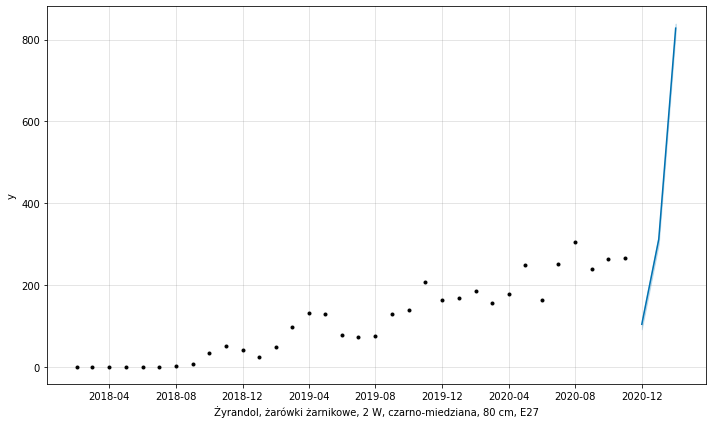

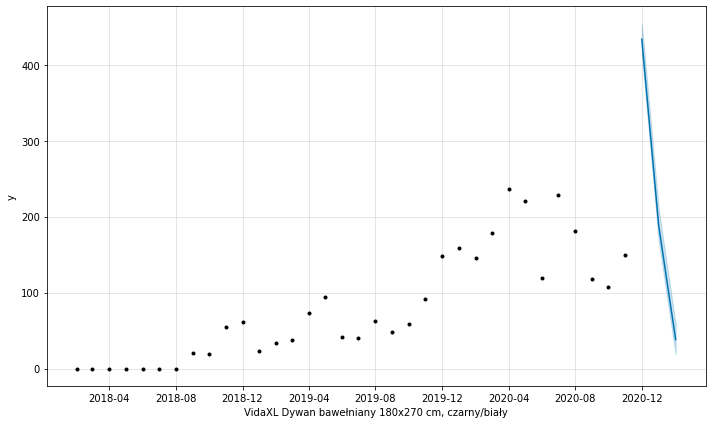

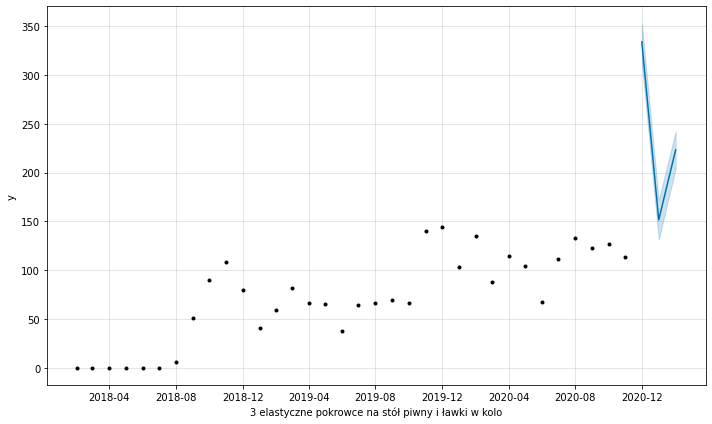

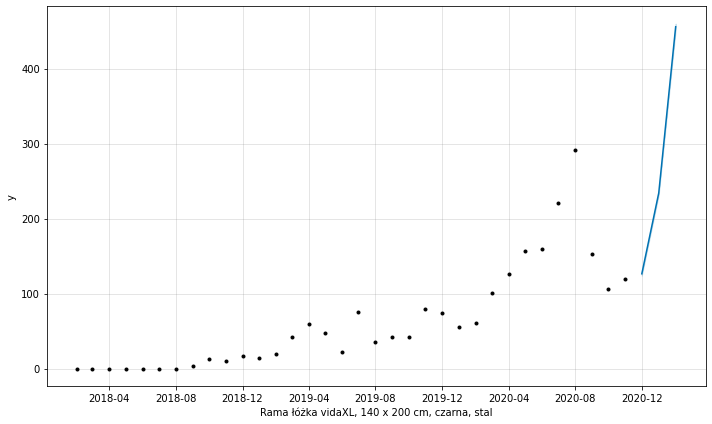

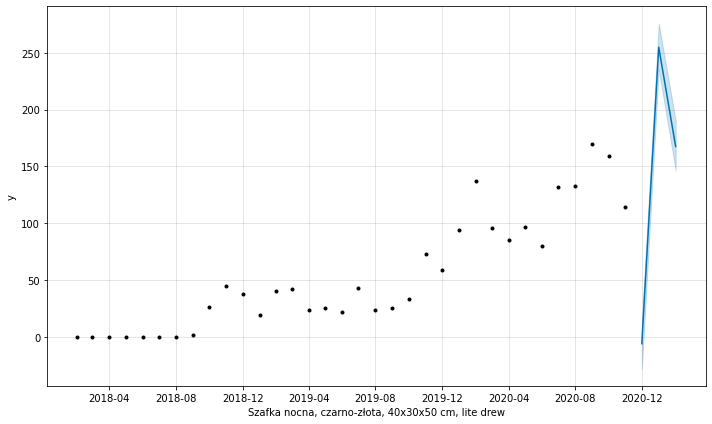

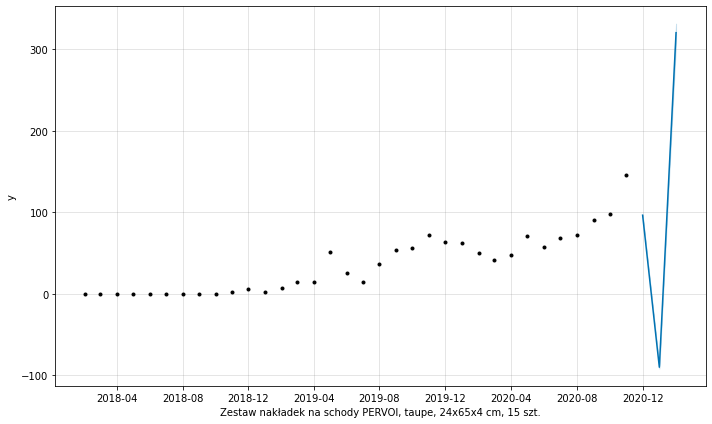

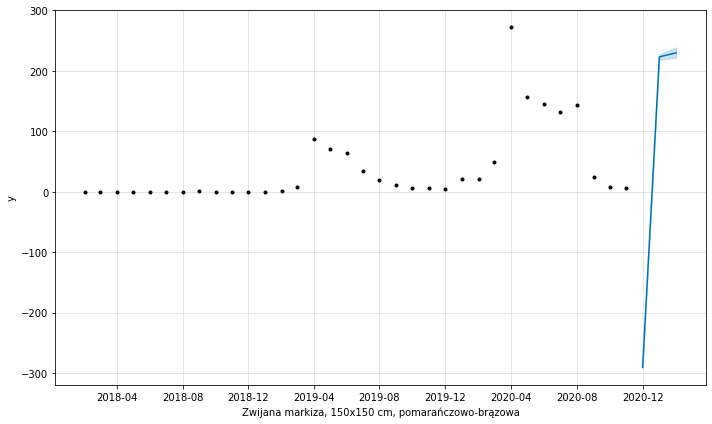

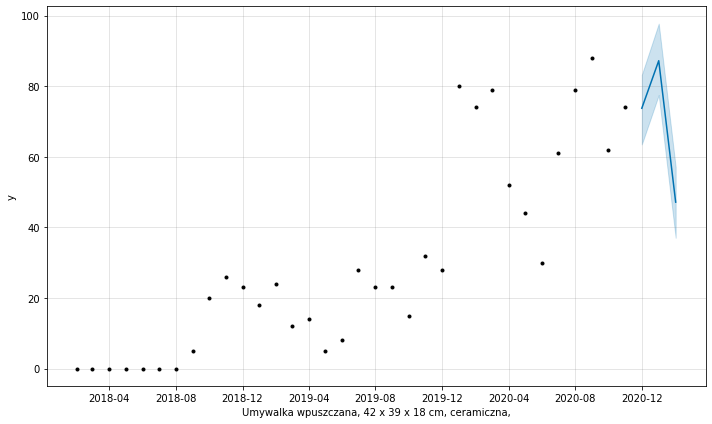

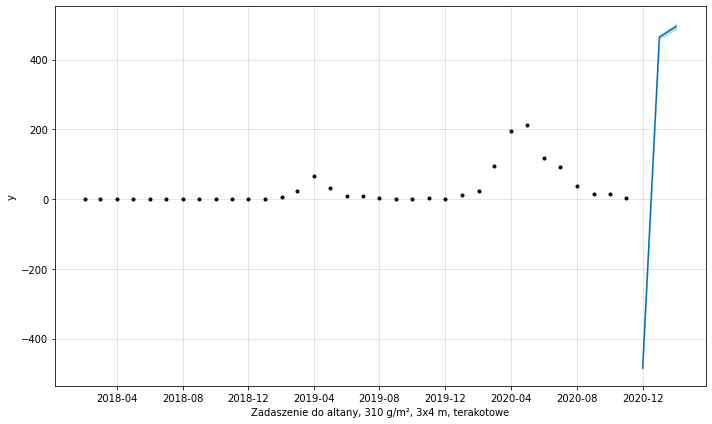

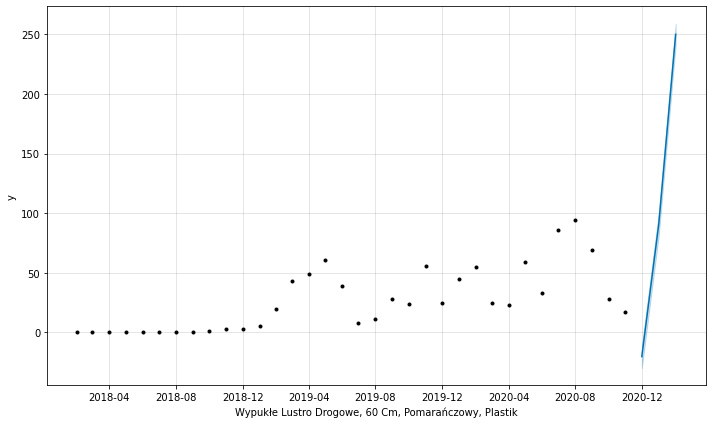

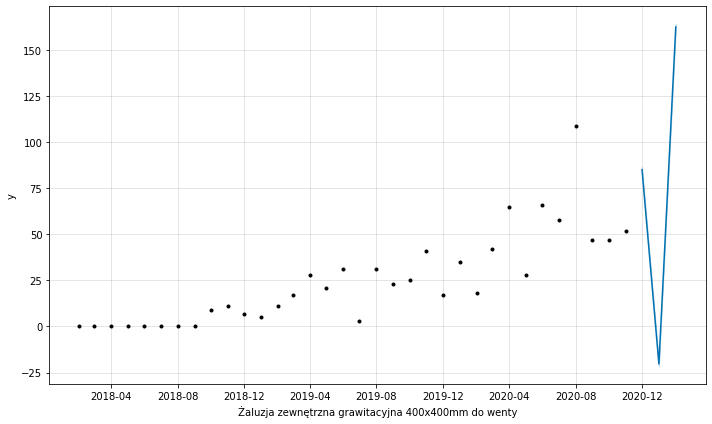

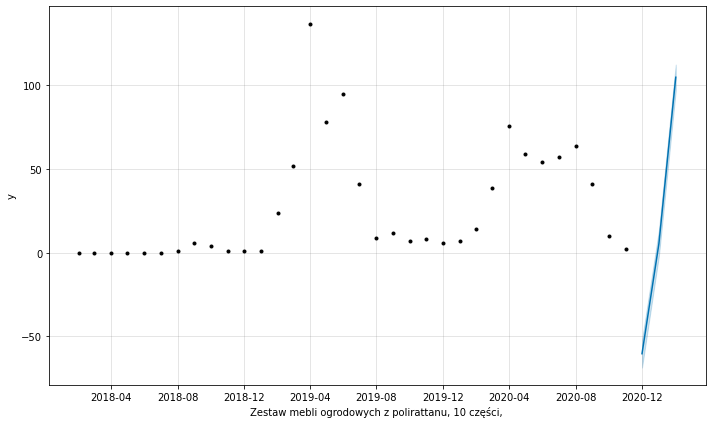

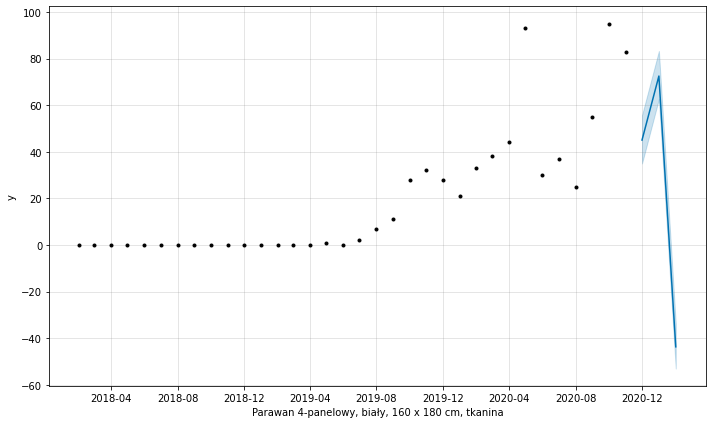

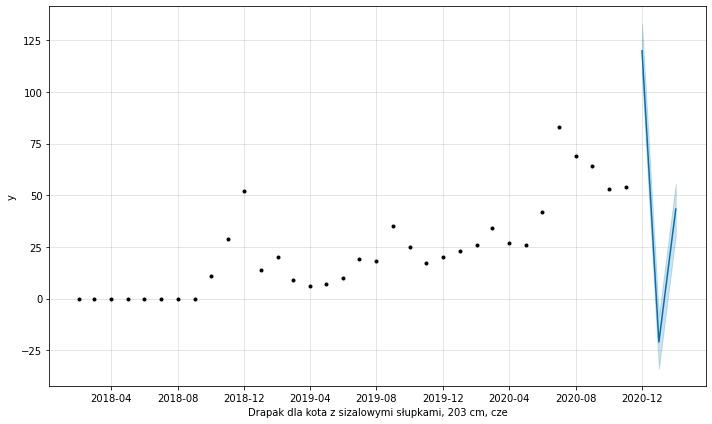

In [35]:
for k in top100sale[1:15]:
    m = Prophet(seasonality_mode='multiplicative')
    # m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.fit(train_DF[k])
    forecast = m.predict(test_DF[k])
    fig1 = m.plot(forecast, xlabel=id_to_product[k])
